<a href="https://colab.research.google.com/github/agprad/cpo_project/blob/main/VRPtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 73.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import pulp
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import itertools


# customer count ('0' is depot)
customer_count = 8

# the number of vehicle
vehicle_count = 20

# the capacity of vehicle
vehicle_capacity = 70

# fix random seed
np.random.seed(seed=777)

# # set depot x and y
# depot_x = 40.748817
# depot_y = -73.985428

df = pd.DataFrame({
    'x': np.random.randint(0, 100, customer_count+1),
    'y': np.random.randint(0, 100, customer_count+1),
    'demand': np.random.randint(1, 20, customer_count+1),
})

df.iloc[0]['x'] = 0
df.iloc[0]['y'] = 0
df.iloc[0]['demand'] = 0
df



,x,y,demand
0,0,0,0
1,59,24,6
2,38,39,8
3,87,18,2
4,49,13,8
5,71,14,11
6,29,32,19
7,39,91,19
8,89,65,8


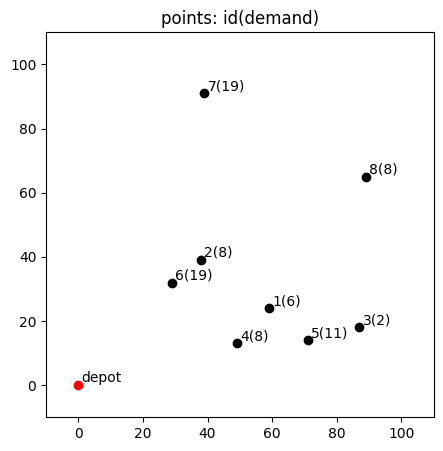

In [ ]:
# check VRP state

plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        demand = row['demand']
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}({demand})')

plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id(demand)')
plt.show()

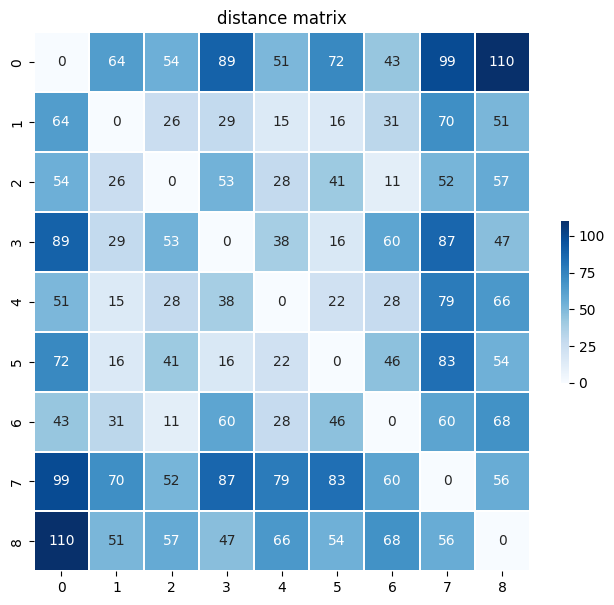

Vehicle Requirements: 2
Moving Distance: 377.87391944766756


In [ ]:
# function for calculating distance between two pins
def _distance_calculator(_df):
    distances = pd.DataFrame(distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values), index=df.index, columns=df.index).values

    fig, ax = plt.subplots(figsize=(8, 7))
    sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
    plt.title('distance matrix')
    plt.show()
    return distances

distance = _distance_calculator(df)


# solve with pulp
for vehicle_count in range(1,vehicle_count+1):

    # definition of LpProblem instance
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    # definition of variables which are 0/1
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]

    # add objective function
    problem += pulp.lpSum(distance[i][j] * x[i][j][k] if i != j else 0
                          for k in range(vehicle_count)
                          for j in range(customer_count)
                          for i in range (customer_count))

    # constraints
    #one vehicle visits one customer
    for j in range(1, customer_count):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0
                              for i in range(customer_count)
                              for k in range(vehicle_count)) == 1

    # all vehicles depart and arrive at the depot
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 1

    # flow balance
    for k in range(vehicle_count):
        for j in range(customer_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(customer_count)) -  pulp.lpSum(x[j][i][k] for i in range(customer_count)) == 0

    #capacity constraint
    for k in range(vehicle_count):
        problem += pulp.lpSum(df.demand[j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (1,customer_count)) <= vehicle_capacity


    # subtour elimination
    subtours = []
    for i in range(2,customer_count):
         subtours += itertools.combinations(range(1,customer_count), i)

    for s in subtours:
        problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1

    # print vehicle_count which needed for solving problem
    # print calculated minimum distance value
    if problem.solve() == 1:
        print('Vehicle Requirements:', vehicle_count)
        print('Moving Distance:', pulp.value(problem.objective))
        break




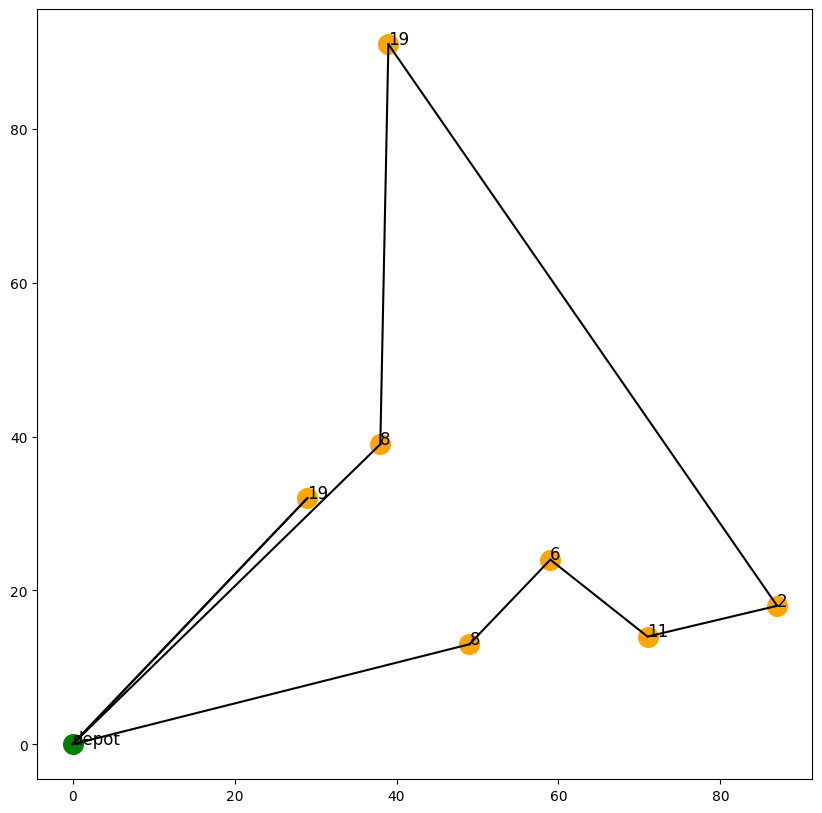

In [ ]:

# visualization : plotting with matplolib
plt.figure(figsize=(10,10))
for i in range(customer_count):
    if i == 0:
        plt.scatter(df.x[i], df.y[i], c='green', s=200)
        plt.text(df.x[i], df.y[i], "depot", fontsize=12)
    else:
        plt.scatter(df.x[i], df.y[i], c='orange', s=200)
        plt.text(df.x[i], df.y[i], str(df.demand[i]), fontsize=12)

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.plot([df.x[i], df.x[j]], [df.y[i], df.y[j]], c="black")

plt.show()